<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/NB3.3_Prediction_with_Limit_Order_Book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Price prediction and trading signal generation using limit order book data

---

This notebook showcases how a deep learning model can be developed to predict asset price movement, and in turn how some automated trading strategies can be obtained.

Import some packages to be used.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the data file

The first step is to import the csv data file and load its content. The key tool is the command "pd.read_csv" which is a pandas function opening a csv file given its file path and then it assigns the values to a dataframe variable.

If you are running the Python script locally on your computer (i.e. using something like Jupyter but not on Colab), you should change the filepath based on where you save the data file.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#PATH = '/content/drive/My Drive/Data/crypto/lob/'
#filepath = os.path.join(PATH, 'btc_lob_20191112_20191120_10s.csv')

####################################################################
# If you have a csv file locally on your computer, then it is not very convenient to use Colab
# because you cannot easily access your local file from Colab.
# If you really want to use Colab, one solution is to save the csv file on your Google Drive
# and then mount your drive using the package "from google.colab import drive"

# If you run the notebook on Jupyer, then replace the filepath variable below as somethinig like
# filepath = 'C:\Users\yourname\Documents\btc_lob_20191112_20191120_10s.csv'
####################################################################

filepath = 'https://www.dropbox.com/s/lna90uuyos88cqh/btc_lob_20191112_20191120_10s.csv?dl=1'

# Open and save the file content to a dataframe variable called "data"
data = pd.read_csv(filepath)

# Take a look at the loaded data
display(data)

,timestamp,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,...,aq11,aq12,aq13,aq14,aq15,aq16,aq17,aq18,aq19,aq20,aq21,aq22,aq23,aq24,aq25,aq26,aq27,aq28,aq29,aq30,aq31,aq32,aq33,aq34,aq35,aq36,aq37,aq38,aq39,aq40,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50
0,2019-11-12 00:00:00,8721.53,8720.59,8720.01,8719.53,8719.00,8718.66,8718.63,8717.09,8716.60,8716.09,8716.08,8716.06,8716.00,8715.29,8715.00,8714.61,8714.20,8713.75,8713.20,8712.41,8712.09,8710.56,8710.55,8710.00,8708.91,8708.69,8708.68,8708.19,8708.13,8707.99,8707.85,8705.89,8705.21,8705.00,8704.09,8704.08,8703.00,8701.50,8700.99,...,0.001890,0.080000,0.630745,1.000000,5.999000,0.002240,4.10000,1.000000,0.005000,0.001889,1.000000,1.000000,0.001000,2.000000,0.002117,1.500000,0.010000,0.406400,0.687130,0.250000,1.141294,3.50000,0.092358,0.68813,0.671000,0.233500,0.689853,0.747313,1.042177,0.009135,8.200000,2.203000,2.600000,0.005000,2.500000,0.896321,0.001,0.766000,0.001737,1.820000
1,2019-11-12 00:00:10,8720.78,8720.77,8720.76,8720.75,8720.73,8720.64,8720.59,8720.58,8719.00,8718.98,8718.80,8718.09,8717.72,8716.40,8716.08,8716.00,8715.52,8715.29,8715.00,8714.61,8712.50,8712.38,8712.12,8711.20,8710.70,8710.64,8710.55,8710.00,8708.69,8707.99,8705.89,8705.00,8704.09,8704.08,8703.00,8702.18,8701.50,8701.41,8700.60,...,0.038468,0.200000,0.001890,0.630750,5.999000,1.000000,0.00224,1.000000,0.005000,0.001889,1.012422,1.000000,4.100000,1.000000,0.001000,0.002117,1.500000,2.000000,0.687130,0.250000,1.152705,3.50000,0.092358,0.68813,0.671000,0.233500,0.689853,0.747313,0.835086,0.009135,2.203000,2.600000,0.005000,2.500000,1.236624,0.010000,8.200,0.001000,0.766000,0.001737
2,2019-11-12 00:00:20,8720.60,8720.59,8719.01,8719.00,8718.44,8718.37,8717.47,8717.26,8716.56,8716.40,8716.00,8715.29,8715.12,8715.00,8714.88,8714.61,8713.72,8713.02,8712.99,8712.50,8712.12,8711.20,8710.55,8710.01,8710.00,8709.55,8708.69,8708.54,8708.12,8707.99,8707.14,8705.89,8705.00,8704.50,8704.09,8704.08,8703.00,8702.18,8701.98,...,0.630842,0.038468,0.080000,1.152147,0.001890,4.100000,1.00000,0.002240,5.999000,1.000000,0.005000,1.500000,1.000000,1.124474,1.000000,0.001000,0.002117,1.500000,2.203000,2.000000,0.101199,0.68713,0.396700,0.25000,1.087775,3.500000,0.688130,0.671000,0.233500,0.689853,0.747313,0.009135,8.200000,1.090858,2.600000,1.640000,0.005,2.500000,0.010000,0.850376
3,2019-11-12 00:00:30,8720.60,8720.59,8720.14,8720.13,8719.01,8719.00,8718.30,8717.69,8716.56,8716.47,8716.40,8716.00,8715.67,8715.29,8715.00,8714.88,8714.61,8713.57,8713.03,8713.02,8712.99,8712.82,8712.50,8712.12,8710.56,8710.55,8710.00,8708.69,8707.99,8707.24,8707.14,8705.89,8705.64,8705.00,8704.50,8704.09,8704.08,8703.00,8702.18,...,0.460000,0.038468,0.080000,1.000000,0.630809,0.500293,0.00189,4.100000,1.000000,1.124474,0.002240,5.999000,1.000000,0.005000,1.500000,0.407000,1.000000,0.001000,0.002117,1.500000,2.203000,2.00000,0.101199,0.68713,0.250000,1.087775,3.500000,8.200000,2.500000,0.688130,0.671000,0.233500,0.689853,0.747313,0.009135,1.090858,2.600,1.640000,0.005000,0.010000
4,2019-11-12 00:00:40,8721.38,8720.61,8720.60,8720.59,8720.13,8719.00,8718.99,8718.55,8718.06,8717.94,8717.50,8716.40,8716.07,8716.00,8715.29,8715.00,8714.61,8714.32,8713.03,8713.02,8712.99,8712.50,8712.12,8710.96,8710.55,8710.00,8708.69,8708.63,8708.38,8707.99,8707.24,8706.07,8705.89,8705.00,8704.09,8704.08,8703.27,8703.00,8702.18,...,0.060000,1.124474,0.500293,0.630750,0.001890,1.000000,0.00224,5.999000,1.000000,0.005000,1.500000,4.100000,0.002576,2.000000,0.001000,0.002117,0.395000,1.500000,2.000000,1.090858,0.687130,0.25000,3.500000,2.50000,0.152211,1.183689,0.688130,0.744000,0.233500,0.689853,0.747313,0.009135,2.203000,8.200000,2.600000,0.005000,0.010,0.001000,0.766000,0.001737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

As mentioned in the lecture notes, it is a multivariate time series with 200 channels, consisting of 50 levels of information regarding bid price, bid size, ask price and ask size. The data is snapped at every 10 seconds.

# Inspect the data

The first step we should do is to check if there are any missing (i.e. NaN) values within the data. We can do this by the pandas function "isnull()", which counts the total number of missing values per column.

For our interest, we can also look at the size of the data in terms of computer memory usage.

In [ ]:
print('Number of missing data: ',  data.isnull().sum())
print('Memory Usage: {} GB'.format(data.memory_usage().sum()/(1024**3)))

Number of missing data:  timestamp    0
b1           1
b2           1
b3           1
b4           1
            ..
aq46         1
aq47         1
aq48         1
aq49         1
aq50         1
Length: 201, dtype: int64
Memory Usage: 0.11645090579986572 GB


The above output is suggesting that, for each column, there is one NaN (missing) value. Let's try to drop the problematic rows with NaN values by the function dropna().

In [ ]:
data = data.dropna()
print('Number of missing data: ',  data.isnull().sum())

Number of missing data:  timestamp    0
b1           0
b2           0
b3           0
b4           0
            ..
aq46         0
aq47         0
aq48         0
aq49         0
aq50         0
Length: 201, dtype: int64


We may also want to do a quick check on the data to confirm if there is anything unusual. The function "describe()" returns the summary statistics of the data. Usually a good place to look at is the max/min value of each column. Then we can quickly tell if the data has been contaminated by some erroneous values/outliers.

In [ ]:
data.describe()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,...,aq11,aq12,aq13,aq14,aq15,aq16,aq17,aq18,aq19,aq20,aq21,aq22,aq23,aq24,aq25,aq26,aq27,aq28,aq29,aq30,aq31,aq32,aq33,aq34,aq35,aq36,aq37,aq38,aq39,aq40,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50
count,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,...,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000,77759.000000
mean,8471.551445,8470.934675,8470.431025,8469.964118,8469.511455,8469.046704,8468.580431,8468.115937,8467.661727,8467.214401,8466.772456,8466.343497,8465.921015,8465.508907,8465.101540,8464.697451,8464.296630,8463.893106,8463.486664,8463.077210,8462.668014,8462.249901,8461.827131,8461.399777,8460.970477,8460.538078,8460.100965,8459.663245,8459.220123,8458.772770,8458.328462,8457.881536,8457.433780,8456.987132,8456.541900,8456.096190,8455.650393,8455.204835,8454.762173,8454.323245,...,1.332993,1.377251,1.403719,1.452934,1.485371,1.493768,1.505126,1.524096,1.532874,1.570209,1.564983,1.590740,1.579537,1.579287,1.583592,1.584870,1.599219,1.572107,1.600052,1.599484,1.593931,1.615375,1.585414,1.594855,1.590107,1.578974,1.526738,1.505613,1.506330,1.500271,1.498853,1.480950,1.469061,1.477934,1.467596,1.459390,1.476861,1.454102,1.482390,1.495346
std,232.272478,232.292829,232.272524,232.258186,232.237240,232.216910,232.201365,232.191990,232.181827,232.177294,232.174411,232.171281,232.168194,232.167355,232.166625,232.160067,232.152814,232.143995,232.135212,232.122775,232.110386,232.098439,232.086407,232.074058,232.063425,232.051450,232.038806,232.025803,232.011309,231.999653,231.984154,231.969083,231.961398,231.951825,231.944042,231.935122,231.926265,231.920144,231.918247,231.914607,...,2.132236,2.180875,2.205943,2.208400,2.281942,2.155954,2.116606,2.077269,2.101078,2.289333,2.242400,2.323336,2.281579,2.287037,2.332178,2.283680,2.349150,2.328492,2.375154,2.418078,2.410836,2.460461,2.406609,2.474030,2.461123,2.492536,2.470886,2.385494,2.364134,2.424855,2.454947,2.537816,2.468170,2.514692,2.508961,2.575805,2.740889,2.683752,2.823337,2.909033
min,7987.070000,7987.050000,7987.040000,7987.030000,7986.990000,7986.980000,7985.000000,7984.820000,7983.450000,7983.440000,7982.960000,7981.890000,7981.010000,7980.090000,7980.080000,7980.000000,7979.800000,7979.790000,7979.690000,7979.400000,7979.000000,7978.780000,7978.610000,7978.000000,7977.550000,7977.480000,7977.050000,7977.000000,7976.630000,7976.550000,7976.520000,7976.260000,7976.070000,7976.000000,7975.570000,7975.560000,7975.000000,7974.560000,7973.430000,7972.580000,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000276,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.001000,0.000276,0.000008,0.000276,0.000008,0.000008
25%,8318.790000,8318.040000,8317.905000,8316.900000,8316.685000,8315.965000,8315.660000,8

# Create the target labels

Now let's define some new columns related to our prediction task. We want to predict the percentage change of the mid price in the next six time steps. So let's create some new columns containing the the mid price, the mid price six time steps later, and the percentage return.

We first create a column containing the mid price and plot its path over time.

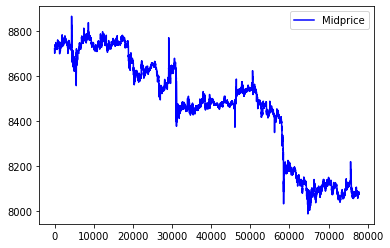

In [ ]:
data['mid'] = (data['b1'] + data['a1']) / 2
plt.plot(data['mid'], 'b-', label="Midprice")
plt.legend()

We now compute the percentage change in the mid price over the next six time steps. Note that we multiply the percentage by $100\times 24\times 60$, so this number can be interpreted as the % return on the scale of one day (24 hours per day, and 60 mins per hour).

In [ ]:
data['mid(t+6)'] = data['mid'].shift(-6)
data['mid_return(t,t+6)'] = (data['mid(t+6)'] - data['mid']) / data['mid'] * 100 * 24 * 60

data = data.dropna()
data.describe()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,...,aq14,aq15,aq16,aq17,aq18,aq19,aq20,aq21,aq22,aq23,aq24,aq25,aq26,aq27,aq28,aq29,aq30,aq31,aq32,aq33,aq34,aq35,aq36,aq37,aq38,aq39,aq40,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,mid,mid(t+6),"mid_return(t,t+6)"
count,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,...,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000,77753.000000
mean,8471.581431,8470.964640,8470.460971,8469.994066,8469.541413,8469.076651,8468.610395,8468.145920,8467.691706,8467.244405,8466.802473,8466.373537,8465.951048,8465.538966,8465.131589,8464.727523,8464.326701,8463.923166,8463.516704,8463.107247,8462.698058,8462.279951,8461.857161,8461.429826,8461.000524,8460.568145,8460.131038,8459.693306,8459.250177,8458.802846,8458.358543,8457.911607,8457.463863,8457.017193,8456.571959,8456.126230,8455.680429,8455.234882,8454.792204,8454.353280,...,1.453018,1.485286,1.493824,1.505132,1.524079,1.532852,1.570269,1.564938,1.590793,1.579592,1.579363,1.583673,1.584919,1.599248,1.572179,1.599985,1.599491,1.593902,1.615330,1.585283,1.594801,1.590205,1.579018,1.526826,1.505590,1.506411,1.500332,1.498942,1.481015,1.469137,1.477994,1.467615,1.459471,1.476944,1.453915,1.482417,1.495303,8471.656559,8471.607341,-0.821573
std,232.256354,232.276742,232.256468,232.242123,232.221158,232.200843,232.185267,232.175859,232.165702,232.161126,232.158220,232.155052,232.151978,232.151094,232.150380,232.143783,232.136530,232.127729,232.118979,232.106544,232.094142,232.082183,232.070182,232.057800,232.047169,232.035158,232.022501,232.009516,231.995031,231.983339,231.967827,231.952771,231.945065,231.935527,231.927748,231.918857,231.910006,231.903866,231.901995,231.898349,...,2.208461,2.281946,2.155990,2.116614,2.077300,2.101103,2.289411,2.242420,2.323386,2.281652,2.287105,2.332240,2.283751,2.349228,2.328552,2.375092,2.418150,2.410765,2.460395,2.406393,2.473956,2.461191,2.492606,2.470959,2.385537,2.364204,2.424913,2.455017,2.537900,2.468246,2.514777,2.509045,2.575885,2.740968,2.683533,2.823432,2.908991,232.304519,232.319250,80.250569
min,7987.070000,7987.050000,7987.040000,7987.030000,7986.990000,7986.980000,7985.000000,7984.820000,7983.450000,7983.440000,7982.960000,7981.890000,7981.010000,7980.090000,7980.080000,7980.000000,7979.800000,7979.790000,7979.690000,7979.400000,7979.000000,7978.780000,7978.610000,7978.000000,7977.550000,7977.480000,7977.050000,7977.000000,7976.630000,7976.550000,7976.520000,7976.260000,7976.070000,7976.000000,7975.570000,7975.560000,7975.000000,7974.560000,7973.430000,7972.580000,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000276,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.001000,0.000276,0.000008,0.000276,0.000008,0.000008,7987.420000,7987.420000,-2178.860016
25%,8319.030000,8318.470000,8318.000000,8317.0400

From the above summary statistics, the median of 'mid_return(t,t+6)' is zero. It turns out that there is quite a large proportion of data without any mid price changes (which makese sense since the time scale we consider is quite small).

In [ ]:
print("Proportion of data with mid price return exactly equal zero: ", np.sum(data['mid_return(t,t+6)'] == 0)/len(data))

Proportion of data with mid price return exactly equal zero:  0.21217187761243939


Now we can create the target label. It is a classification task on whether the mid price return is larger than a certain threshold or not. We set this threshold to be 2, which roughly corresponds to 2% return at a daily scale.

In [ ]:
threshold = 2

data['target'] = 0
idx = (data['mid_return(t,t+6)'] > threshold)
data.loc[idx, 'target'] = 1

display(data)

,timestamp,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,...,aq15,aq16,aq17,aq18,aq19,aq20,aq21,aq22,aq23,aq24,aq25,aq26,aq27,aq28,aq29,aq30,aq31,aq32,aq33,aq34,aq35,aq36,aq37,aq38,aq39,aq40,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,mid,mid(t+6),"mid_return(t,t+6)",target
0,2019-11-12 00:00:00,8721.53,8720.59,8720.01,8719.53,8719.00,8718.66,8718.63,8717.09,8716.60,8716.09,8716.08,8716.06,8716.00,8715.29,8715.00,8714.61,8714.20,8713.75,8713.20,8712.41,8712.09,8710.56,8710.55,8710.00,8708.91,8708.69,8708.68,8708.19,8708.13,8707.99,8707.85,8705.89,8705.21,8705.00,8704.09,8704.08,8703.00,8701.50,8700.99,...,5.999000,0.002240,4.100000,1.000000,0.005,0.001889,1.000000,1.000000,0.001000,2.000000,0.002117,1.500000,0.010000,0.406400,0.687130,0.250000,1.141294,3.50000,0.092358,0.68813,0.671000,0.233500,0.689853,0.747313,1.042177,0.009135,8.200000,2.203000,2.600000,0.005000,2.500000,0.896321,0.00100,0.766000,0.001737,1.820000,8721.535,8720.605,-15.355095,0
1,2019-11-12 00:00:10,8720.78,8720.77,8720.76,8720.75,8720.73,8720.64,8720.59,8720.58,8719.00,8718.98,8718.80,8718.09,8717.72,8716.40,8716.08,8716.00,8715.52,8715.29,8715.00,8714.61,8712.50,8712.38,8712.12,8711.20,8710.70,8710.64,8710.55,8710.00,8708.69,8707.99,8705.89,8705.00,8704.09,8704.08,8703.00,8702.18,8701.50,8701.41,8700.60,...,5.999000,1.000000,0.002240,1.000000,0.005,0.001889,1.012422,1.000000,4.100000,1.000000,0.001000,0.002117,1.500000,2.000000,0.687130,0.250000,1.152705,3.50000,0.092358,0.68813,0.671000,0.233500,0.689853,0.747313,0.835086,0.009135,2.203000,2.600000,0.005000,2.500000,1.236624,0.010000,8.20000,0.001000,0.766000,0.001737,8721.160,8720.605,-9.163919,0
2,2019-11-12 00:00:20,8720.60,8720.59,8719.01,8719.00,8718.44,8718.37,8717.47,8717.26,8716.56,8716.40,8716.00,8715.29,8715.12,8715.00,8714.88,8714.61,8713.72,8713.02,8712.99,8712.50,8712.12,8711.20,8710.55,8710.01,8710.00,8709.55,8708.69,8708.54,8708.12,8707.99,8707.14,8705.89,8705.00,8704.50,8704.09,8704.08,8703.00,8702.18,8701.98,...,0.001890,4.100000,1.000000,0.002240,5.999,1.000000,0.005000,1.500000,1.000000,1.124474,1.000000,0.001000,0.002117,1.500000,2.203000,2.000000,0.101199,0.68713,0.396700,0.25000,1.087775,3.500000,0.688130,0.671000,0.233500,0.689853,0.747313,0.009135,8.200000,1.090858,2.600000,1.640000,0.00500,2.500000,0.010000,0.850376,8720.715,8720.605,-1.816365,0
3,2019-11-12 00:00:30,8720.60,8720.59,8720.14,8720.13,8719.01,8719.00,8718.30,8717.69,8716.56,8716.47,8716.40,8716.00,8715.67,8715.29,8715.00,8714.88,8714.61,8713.57,8713.03,8713.02,8712.99,8712.82,8712.50,8712.12,8710.56,8710.55,8710.00,8708.69,8707.99,8707.24,8707.14,8705.89,8705.64,8705.00,8704.50,8704.09,8704.08,8703.00,8702.18,...,0.630809,0.500293,0.001890,4.100000,1.000,1.124474,0.002240,5.999000,1.000000,0.005000,1.500000,0.407000,1.000000,0.001000,0.002117,1.500000,2.203000,2.00000,0.101199,0.68713,0.250000,1.087775,3.500000,8.200000,2.500000,0.688130,0.671000,0.233500,0.689853,0.747313,0.009135,1.090858,2.60000,1.640000,0.005000,0.010000,8720.605,8719.005,-26.420185,0
4,2019-11-12 00:00:40,8721.38,8720.61,8720.60,8720.59,8720.13,8719.00,8718.99,8718.55,8718.06,8717.94,8717.50,8716.40,8716.07,8716.00,8715.29,8715.00,8714.61,8714.32,8713.03,8713.02,8712.99,8712.50,8712.12,8710.96,8710.55,8710.00,8708.69,8708.63,8708.38,8707.99,8707.24,8706.07,8705.89,8705.00,8704.09,8704.08,8703.27,8703.00,8702.18,...,0.001890,1.000000,0.002240,5.999000,1.000,0.005000,1.500000,4.100000,0.002576,2.000000,0.001000,0.002117,0.395000,1.500000,2.000000,1.090858,0.687130,0.25000,3.500000,2.50000,0.152211,1.183689,0.688130,0.744000,0.233500,0.689853,0.747313,0.009135,2.203000,8.200000,2.600000,0.005000,0.01000,0.001000,0.766000,0.001737,8721.430,8710.005,-188.638790,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

We can look at the proportion of data where we observe the positive outcomes (i.e. mid return higher than the threshold).

In [ ]:
print("Proportion of positive label: ", np.sum(data['target'])/len(data))

Proportion of positive label:  0.36131081758903194


The proportion of positive label is not a big number. This phenomenon is known as "imbalanced data" where we do not have sufficient and even samples to estimate the likelihood of each possible catagory.

One strategy we could try is "downsampling", where we manually remove some (or all) observations that are "not important". In our problem, there are many data points with zero mid price change. Those observations are not too helpful since we want our model to learn when the asset will show a large positive move (rather than to learn when the asset will not move).

In [ ]:
# Drop all the rows where mid return is exactly zero
data = data.loc[data['mid_return(t,t+6)']!=0]

print("Proportion of data with mid price return exactly equal zero: ", np.sum(data['mid_return(t,t+6)'] == 0)/len(data))
print("Proportion of positive label: ", np.sum(data['target'])/len(data))

Proportion of data with mid price return exactly equal zero:  0.0
Proportion of positive label:  0.458616298811545


In the code below, we create a list which contains all the column names corresponding to the features we want to use.

There are 200 channels provided by the data from the 50 levels of the LOB. But in practice, only the levels closer to the top end are economically significant. Hence we can work with a smaller subset of the features, say just the information from the first 15 levels (and hence we are using $4\times 15=60$ channels).

If for any reasons there are some columns in the time series we want or don't want to use in the prediction task, we can modify the code below to reflect this.

In [ ]:
list_of_features = []

# use features up to level 15 in the LOB
for i in range(15):
    list_of_features.append('b' + str(i+1))
    list_of_features.append('a' + str(i+1))
    list_of_features.append('bq' + str(i+1))
    list_of_features.append('aq' + str(i+1))

print(list_of_features)

['b1', 'a1', 'bq1', 'aq1', 'b2', 'a2', 'bq2', 'aq2', 'b3', 'a3', 'bq3', 'aq3', 'b4', 'a4', 'bq4', 'aq4', 'b5', 'a5', 'bq5', 'aq5', 'b6', 'a6', 'bq6', 'aq6', 'b7', 'a7', 'bq7', 'aq7', 'b8', 'a8', 'bq8', 'aq8', 'b9', 'a9', 'bq9', 'aq9', 'b10', 'a10', 'bq10', 'aq10', 'b11', 'a11', 'bq11', 'aq11', 'b12', 'a12', 'bq12', 'aq12', 'b13', 'a13', 'bq13', 'aq13', 'b14', 'a14', 'bq14', 'aq14', 'b15', 'a15', 'bq15', 'aq15']


# Preparation of the training and validation data

Now we split the data into the training and validation set. We impose a cutoff time where the observations before (resp. after) the cutoff is treated as training (validation) data. We split the data in a proportion of 8:2.

In [ ]:
num_train = int(len(data)*0.8)
train_data = data[:num_train]
valid_data = data[num_train:]

# We reset the index in the dataframes since they still "remember" their old indexing from the original dataframe
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

display(train_data)
display(valid_data)

del data # delete the original dataframe to release computer memory

,timestamp,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,...,aq15,aq16,aq17,aq18,aq19,aq20,aq21,aq22,aq23,aq24,aq25,aq26,aq27,aq28,aq29,aq30,aq31,aq32,aq33,aq34,aq35,aq36,aq37,aq38,aq39,aq40,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,mid,mid(t+6),"mid_return(t,t+6)",target
0,2019-11-12 00:00:00,8721.53,8720.59,8720.01,8719.53,8719.00,8718.66,8718.63,8717.09,8716.60,8716.09,8716.08,8716.06,8716.00,8715.29,8715.00,8714.61,8714.20,8713.75,8713.20,8712.41,8712.09,8710.56,8710.55,8710.00,8708.91,8708.69,8708.68,8708.19,8708.13,8707.99,8707.85,8705.89,8705.21,8705.00,8704.09,8704.08,8703.00,8701.50,8700.99,...,5.999000,0.002240,4.100000,1.000000,0.005000,0.001889,1.000000,1.000000,0.001000,2.000000,0.002117,1.500000,0.010000,0.406400,0.687130,0.250000,1.141294,3.500000,0.092358,0.688130,0.671000,0.233500,0.689853,0.747313,1.042177,0.009135,8.200000,2.203000,2.600000,0.005000,2.500000,0.896321,0.001000,0.766000,0.001737,1.820000,8721.535,8720.605,-15.355095,0
1,2019-11-12 00:00:10,8720.78,8720.77,8720.76,8720.75,8720.73,8720.64,8720.59,8720.58,8719.00,8718.98,8718.80,8718.09,8717.72,8716.40,8716.08,8716.00,8715.52,8715.29,8715.00,8714.61,8712.50,8712.38,8712.12,8711.20,8710.70,8710.64,8710.55,8710.00,8708.69,8707.99,8705.89,8705.00,8704.09,8704.08,8703.00,8702.18,8701.50,8701.41,8700.60,...,5.999000,1.000000,0.002240,1.000000,0.005000,0.001889,1.012422,1.000000,4.100000,1.000000,0.001000,0.002117,1.500000,2.000000,0.687130,0.250000,1.152705,3.500000,0.092358,0.688130,0.671000,0.233500,0.689853,0.747313,0.835086,0.009135,2.203000,2.600000,0.005000,2.500000,1.236624,0.010000,8.200000,0.001000,0.766000,0.001737,8721.160,8720.605,-9.163919,0
2,2019-11-12 00:00:20,8720.60,8720.59,8719.01,8719.00,8718.44,8718.37,8717.47,8717.26,8716.56,8716.40,8716.00,8715.29,8715.12,8715.00,8714.88,8714.61,8713.72,8713.02,8712.99,8712.50,8712.12,8711.20,8710.55,8710.01,8710.00,8709.55,8708.69,8708.54,8708.12,8707.99,8707.14,8705.89,8705.00,8704.50,8704.09,8704.08,8703.00,8702.18,8701.98,...,0.001890,4.100000,1.000000,0.002240,5.999000,1.000000,0.005000,1.500000,1.000000,1.124474,1.000000,0.001000,0.002117,1.500000,2.203000,2.000000,0.101199,0.687130,0.396700,0.250000,1.087775,3.500000,0.688130,0.671000,0.233500,0.689853,0.747313,0.009135,8.200000,1.090858,2.600000,1.640000,0.005000,2.500000,0.010000,0.850376,8720.715,8720.605,-1.816365,0
3,2019-11-12 00:00:30,8720.60,8720.59,8720.14,8720.13,8719.01,8719.00,8718.30,8717.69,8716.56,8716.47,8716.40,8716.00,8715.67,8715.29,8715.00,8714.88,8714.61,8713.57,8713.03,8713.02,8712.99,8712.82,8712.50,8712.12,8710.56,8710.55,8710.00,8708.69,8707.99,8707.24,8707.14,8705.89,8705.64,8705.00,8704.50,8704.09,8704.08,8703.00,8702.18,...,0.630809,0.500293,0.001890,4.100000,1.000000,1.124474,0.002240,5.999000,1.000000,0.005000,1.500000,0.407000,1.000000,0.001000,0.002117,1.500000,2.203000,2.000000,0.101199,0.687130,0.250000,1.087775,3.500000,8.200000,2.500000,0.688130,0.671000,0.233500,0.689853,0.747313,0.009135,1.090858,2.600000,1.640000,0.005000,0.010000,8720.605,8719.005,-26.420185,0
4,2019-11-12 00:00:40,8721.38,8720.61,8720.60,8720.59,8720.13,8719.00,8718.99,8718.55,8718.06,8717.94,8717.50,8716.40,8716.07,8716.00,8715.29,8715.00,8714.61,8714.32,8713.03,8713.02,8712.99,8712.50,8712.12,8710.96,8710.55,8710.00,8708.69,8708.63,8708.38,8707.99,8707.24,8706.07,8705.89,8705.00,8704.09,8704.08,8703.27,8703.00,8702.18,...,0.001890,1.000000,0.002240,5.999000,1.000000,0.005000,1.500000,4.100000,0.002576,2.000000,0.001000,0.002117,0.395000,1.500000,2.000000,1.090858,0.687130,0.250000,3.500000,2.500000,0.152211,1.183689,0.688130,0.744000,0.233500,0.689853,0.747313,0.009135,2.203000,8.200000,2.600000,0.005000,0.010000,0.001000,0.766000,0.001737,8721.430,8710.005,-188.638790,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

,timestamp,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,...,aq15,aq16,aq17,aq18,aq19,aq20,aq21,aq22,aq23,aq24,aq25,aq26,aq27,aq28,aq29,aq30,aq31,aq32,aq33,aq34,aq35,aq36,aq37,aq38,aq39,aq40,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,mid,mid(t+6),"mid_return(t,t+6)",target
0,2019-11-19 05:23:20,8148.72,8148.45,8148.06,8148.00,8147.99,8147.62,8146.98,8146.96,8146.52,8145.81,8145.00,8144.71,8144.39,8144.37,8144.31,8143.63,8142.85,8142.84,8142.80,8141.80,8140.96,8140.93,8140.85,8139.48,8139.43,8139.10,8139.02,8138.89,8138.19,8136.99,8136.93,8136.63,8136.22,8135.97,8135.94,8135.11,8135.00,8133.47,8133.00,...,0.060000,0.007960,1.225587,0.001675,0.080000,1.000000,1.000000,0.674823,0.736150,3.999000,2.000000,0.914195,3.9990,2.660000,1.059267,9.000000,0.002000,2.265937,0.388000,0.735220,0.679965,4.130000,0.997828,1.000000,0.011656,0.005828,1.221958,0.170000,0.73484,2.5000,0.002000,0.157400,0.200000,0.005827,0.005827,0.006000,8148.725,8147.455,-22.442775,0
1,2019-11-19 05:23:30,8148.72,8148.45,8147.01,8146.96,8146.52,8146.39,8146.38,8145.81,8145.00,8144.37,8144.31,8144.11,8143.53,8143.38,8142.84,8142.03,8141.80,8141.51,8141.50,8140.96,8140.93,8139.57,8139.48,8139.43,8139.10,8139.02,8138.89,8137.46,8136.99,8136.93,8136.63,8136.22,8135.97,8135.94,8135.11,8135.00,8134.32,8133.00,8132.64,...,0.007960,0.080000,0.001675,1.000000,1.059267,1.000000,0.736150,3.999000,2.000000,0.997828,3.999000,2.660000,9.0000,1.221958,0.162590,0.002000,2.265937,0.388000,0.735220,0.679965,4.130000,0.853881,1.000000,0.011656,0.005828,0.170000,0.734840,2.500000,0.00200,0.1574,0.200000,0.005827,0.005827,0.006000,0.026289,0.660000,8148.725,8147.455,-22.442775,0
2,2019-11-19 05:23:40,8148.72,8148.45,8147.01,8146.96,8146.52,8146.39,8145.92,8145.81,8145.00,8144.37,8144.31,8144.11,8143.53,8142.84,8142.25,8142.03,8141.80,8141.51,8141.50,8140.96,8140.93,8139.57,8139.48,8139.43,8139.02,8138.89,8138.39,8137.46,8136.99,8136.93,8136.63,8136.22,8135.97,8135.94,8135.11,8135.00,8134.32,8133.00,8132.64,...,0.007960,0.080000,0.001675,1.000000,1.059267,1.000000,3.999000,2.000000,0.736150,2.000000,0.997828,2.660000,9.0000,1.221958,0.162590,0.002000,2.265937,0.388000,0.735220,0.154102,0.679965,4.130000,0.853881,1.000000,0.011656,0.005828,0.170000,0.734840,2.50000,0.0020,0.152306,0.157400,0.200000,0.005827,0.005827,0.006000,8148.725,8147.455,-22.442775,0
3,2019-11-19 05:23:50,8147.92,8146.96,8146.53,8146.52,8146.29,8145.00,8144.37,8144.31,8144.23,8143.53,8142.84,8141.81,8141.80,8141.50,8140.96,8140.93,8139.48,8139.43,8139.39,8139.02,8138.89,8137.08,8136.99,8136.93,8136.63,8136.22,8135.97,8135.94,8135.11,8135.00,8133.00,8132.64,8132.35,8131.91,8131.31,8131.20,8130.82,8130.00,8129.18,...,3.059000,4.500000,1.059267,1.000000,9.902000,0.080000,0.001675,1.000000,0.674903,1.000000,2.000000,0.736150,3.9990,2.000000,2.660000,0.389100,0.162590,9.000000,0.002000,2.265937,0.735220,0.154102,0.679965,4.130000,1.000000,0.011656,0.005828,0.170000,0.73484,2.5000,0.002000,0.152306,0.157400,0.200000,0.005827,0.005827,8147.925,8147.455,-8.306409,0
4,2019-11-19 05:24:00,8147.45,8147.44,8146.99,8146.98,8146.96,8146.52,8146.35,8146.31,8145.00,8144.54,8144.37,8144.31,8144.17,8143.53,8142.84,8141.86,8141.85,8141.80,8141.50,8140.96,8140.93,8139.58,8139.48,8139.43,8139.39,8139.02,8138.89,8137.14,8136.99,8136.93,8136.92,8136.63,8136.56,8136.22,8135.97,8135.94,8135.11,8135.00,8133.87,...,4.500000,0.001675,1.000000,1.204210,0.674878,1.000000,3.999000,2.000000,2.000000,0.894624,2.660000,0.015000,0.3891,0.162590,9.000000,0.002000,2.265937,0.863558,0.735220,0.154102,0.679965,4.130000,1.152662,1.000000,0.011656,0.005828,0.170000,0.734840,2.50000,0.0020,0.152306,0.903051,0.157400,0.200000,0.005827,0.005827,8147.455,8146.525,-16.437035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Next, we normalise the features data. In particular, we substract the feature values by the means of the features from the training set, and then divide the outcomes by the standard deviations of the features from the training set.

It is important to note that for the normalisation of both the training and validation set, we are using the mean and SDs computed from the training set only. This is to ensure that during the training process the model will not have access to information from the validation set, i.e. to prevent data leakage.

In [ ]:
train_mean = train_data[list_of_features].mean()
train_std = train_data[list_of_features].std()

train_data[list_of_features] = (train_data[list_of_features] - train_mean) / train_std
valid_data[list_of_features] = (valid_data[list_of_features] - train_mean) / train_std # use the train_mean and train_sd for validation set as well!!

We are going to use a convolutional neural network to perform the prediction. So we need to prepare the training features data (and validation features data) which shape is consistent with the model requirement.

Here we are using a historical window with 100 observations, which corresponds to around 16 minutes worth of data. Hence, each of our feature data is going to be a 100 by 60 matrix representing a multivariate time series with 100 time steps and 60 channels.

We use a for loop to create the training data. It is conceptually the same as the procedure we have seen in NB4.2.

In [ ]:
window = 100     # corresponding to around 16 mins

x_train, y_train = [], []
for t in range(train_data.shape[0]):

    if t % 5000 == 0:
        print("Training data processing: {} of {} done".format(t, train_data.shape[0]))

    if t + window > train_data.shape[0]:
        break

    x_train.append(train_data.loc[t : t + window - 1, list_of_features])
    y_train.append(train_data.loc[t + window - 1, 'target'])

x_train = np.array(x_train)
y_train = np.array(y_train)


# Do exactly the same for the validation set
x_valid, y_valid = [], []
for t in range(valid_data.shape[0]):

    if t % 5000 == 0:
        print("Validation data processing: {} of {} done".format(t, valid_data.shape[0]))

    if t + window > valid_data.shape[0]:
        break

    x_valid.append(valid_data.loc[t : t + window - 1, list_of_features])
    y_valid.append(valid_data.loc[t + window - 1, 'target'])

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

del train_data
del valid_data

Training data processing: 0 of 49004 done
Training data processing: 5000 of 49004 done
Training data processing: 10000 of 49004 done
Training data processing: 15000 of 49004 done
Training data processing: 20000 of 49004 done
Training data processing: 25000 of 49004 done
Training data processing: 30000 of 49004 done
Training data processing: 35000 of 49004 done
Training data processing: 40000 of 49004 done
Training data processing: 45000 of 49004 done
Validation data processing: 0 of 12252 done
Validation data processing: 5000 of 12252 done
Validation data processing: 10000 of 12252 done


Check the shapes of the data.

In [ ]:
print("Shape of x_train: ", x_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_valid: ", x_valid.shape)
print("Shape of y_valid: ", y_valid.shape)

Shape of x_train:  (48905, 100, 60)
Shape of y_train:  (48905,)
Shape of x_valid:  (12153, 100, 60)
Shape of y_valid:  (12153,)


# Implementation of the deep learning model

We define the following CNN with three convolutional layers (with strides = 1 and symmetric padding on), one global averaging pooling layer and two dense hidden layers. The output layer has a Sigmoid activation function since we are working with classification problem. Binary cross-entrophy is used as loss function.

We also use Dropout to avoid overfitting.

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential()

# First convolutional layer
model.add(tf.keras.layers.Conv1D(filters=64,kernel_size=4, strides=1, padding="SAME", input_shape=(window,len(list_of_features))))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.25))

# Second convolutional layer
model.add(tf.keras.layers.Conv1D(filters=128,kernel_size=3, strides=1, padding="SAME"))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.25))

# Third convolutional layer
model.add(tf.keras.layers.Conv1D(filters=512,kernel_size=3, strides=1, padding="SAME"))
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.25))

# Global average pooling
model.add(tf.keras.layers.GlobalAveragePooling1D())

# Two dense hidden layers
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Final ouutput layer
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.Adam()

model.summary()
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 64)           15424     
                                                                 
 activation (Activation)     (None, 100, 64)           0         
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 128)          24704     
                                                                 
 activation_1 (Activation)   (None, 100, 128)          0         
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 512)          1

Finally we can train our model......!!

In [ ]:
EPOCHS = 20
BATCH_SIZE = 32

r = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_valid,y_valid))

Epoch 1/20
1529/1529 [==============================] - 11s 6ms/step - loss: 0.6895 - acc: 0.5439 - val_loss: 0.7132 - val_acc: 0.5282
Epoch 2/20
1529/1529 [==============================] - 9s 6ms/step - loss: 0.6885 - acc: 0.5442 - val_loss: 0.6921 - val_acc: 0.5282
Epoch 3/20
1529/1529 [==============================] - 10s 7ms/step - loss: 0.6753 - acc: 0.5727 - val_loss: 0.6134 - val_acc: 0.6741
Epoch 4/20
1529/1529 [==============================] - 9s 6ms/step - loss: 0.6467 - acc: 0.6173 - val_loss: 0.6183 - val_acc: 0.6343
Epoch 5/20
1529/1529 [==============================] - 9s 6ms/step - loss: 0.6384 - acc: 0.6278 - val_loss: 0.6090 - val_acc: 0.6531
Epoch 6/20
1529/1529 [==============================] - 9s 6ms/step - loss: 0.6348 - acc: 0.6333 - val_loss: 0.6084 - val_acc: 0.6639
Epoch 7/20
1529/1529 [==============================] - 9s 6ms/step - loss: 0.6323 - acc: 0.6366 - val_loss: 0.6259 - val_acc: 0.6216
Epoch 8/20
1529/1529 [==============================] - 9s 6

# Assessing the quality of the fitted model

To start with, we can look at the training and validation loss over the epochs.

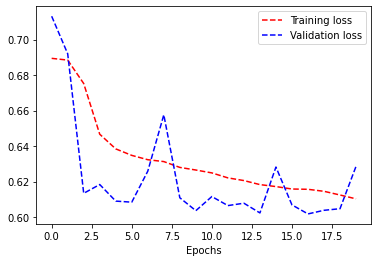

In [ ]:
train_loss = r.history['loss']
val_loss   = r.history['val_loss']

ep = range(EPOCHS)
plt.plot(ep, train_loss, 'r--', label="Training loss")
plt.plot(ep, val_loss, 'b--', label="Validation loss")
plt.xlabel('Epochs')
plt.legend()

For classification task, we can also look at the "accuracy" metric (we have specified this when we compiled the model). This tells us the proportion of observations being correctly classified within the validation set.

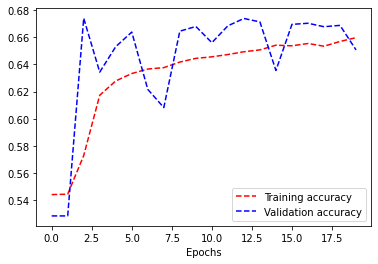

In [ ]:
train_acc = r.history['acc']
val_acc   = r.history['val_acc']

plt.plot(ep, train_acc, 'r--', label="Training accuracy")
plt.plot(ep, val_acc, 'b--', label="Validation accuracy")
plt.xlabel('Epochs')
plt.legend()

Classification accuracy alone may be misleading or not comprehensive enough. We can also look at the so-called "confusion matrix". This computes, based on the validation data, the proportion of true positive, true negative, false positive and false negative. This function is available in the "seaborn" library.

The way to read the matrix below is:

|  | Predict 0 | Predict 1         
| :-: |:-------------: | :-:
|Actual 0| True negative rate  | False positive rate
| Actual 1 | False negative rate | True positive rate


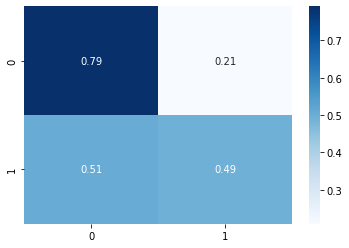

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_valid)
y_pred = (y_pred.flatten() > 0.5).astype(int)

cm = confusion_matrix(y_pred=y_pred, y_true=y_valid)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax=sns.heatmap(cm, annot=True, xticklabels=[0,1], yticklabels=[0,1], cmap='Blues')
plt.show()

# Implementation of a simple algo-trading rule

Now we try to devise a trading algorithm using the fitted model.

At a given time $t$, we use the fitted model to predict $$p_t:=\mathbb{P}\left(\frac{m(t+6)-m(t)}{m(t)}>C\right),$$ which is the probability that the percentrage change in mid price in the next 6 time steps (i.e. one minute) is larger than the given threshold $C$. This can be considered as a trading signal.

We consider a trading rule where we will hold $1$ unit of asset if this probability is larger than 0.5. Mathematically, let $\theta_t$ be our asset holding at time $t$. Then the trading rule is given by $$\theta_t=  I(p_t>0.5)$$ where $I$ is an indicator function.

If we do not adjust our strategy in the next 6 time steps, then the profit-and-loss in the next one-minute interval is given by $$\pi_t=\theta_{t}(m(t+6)-m(t))$$ where we approximate the price of the asset by the mid price in the profit calculation.

If the strategy is implemented from time zero and then repeated every 1 minute (i.e. every 6 time steps), then the total profit is given by $$\sum_{k=0}\pi_{6k}.$$

Let's look at the trading performance if we apply this strategy using the last 24 hours of the dataset (roughly 8640 data points).

In [ ]:
# load the raw data again
data = pd.read_csv(filepath)

# Only keep the last 8640 data points (which roughly covers the last 24 hours)
data=data.tail(8640)

# Work out the mid price, mid price after 1 min, and change in mid price in 1 min again
data['mid'] = (data['b1'] + data['a1']) / 2
data['mid(t+6)'] = data['mid'].shift(-6)
data['mid(t+6)-mid(t)'] = data['mid(t+6)'] - data['mid']

# Drop na values and reset the row index
data=data.dropna()
data = data.reset_index(drop=True)

display(data)

,timestamp,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,...,aq14,aq15,aq16,aq17,aq18,aq19,aq20,aq21,aq22,aq23,aq24,aq25,aq26,aq27,aq28,aq29,aq30,aq31,aq32,aq33,aq34,aq35,aq36,aq37,aq38,aq39,aq40,aq41,aq42,aq43,aq44,aq45,aq46,aq47,aq48,aq49,aq50,mid,mid(t+6),mid(t+6)-mid(t)
0,2019-11-20 00:00:00,8123.35,8123.28,8123.00,8122.48,8121.70,8120.45,8119.71,8119.69,8119.62,8119.12,8118.89,8117.24,8116.81,8116.73,8115.34,8114.88,8114.83,8114.78,8113.82,8113.70,8113.09,8112.86,8112.39,8111.99,8111.10,8111.01,8111.00,8110.68,8110.62,8110.51,8109.86,8109.72,8108.50,8108.16,8107.89,8107.68,8107.65,8106.97,8106.45,...,0.4046,1.000000,0.002500,0.060000,1.174885,0.120000,4.500000,0.365000,4.110000,1.009482,0.800000,0.73793,3.999000,0.005509,0.600000,4.300000,2.000000,1.038696,9.000000,1.000000,2.720000,2.260878,0.929568,0.726000,0.737890,0.600000,0.685254,1.374000,0.157400,0.867240,2.500000,3.900000,0.005000,0.60000,0.161879,0.737890,1.028755,8123.355,8123.355,0.000
1,2019-11-20 00:00:10,8123.35,8123.00,8122.48,8121.75,8121.70,8120.45,8119.71,8119.69,8119.12,8118.68,8118.29,8117.77,8116.81,8116.73,8115.51,8115.34,8114.83,8114.78,8113.82,8113.70,8113.56,8113.09,8112.39,8111.99,8111.10,8111.01,8111.00,8110.68,8110.62,8110.51,8109.97,8109.86,8109.00,8108.50,8108.25,8107.89,8107.68,8107.65,8106.97,...,1.0000,0.002500,4.500000,0.120000,0.060000,0.365000,4.110000,0.929568,0.968227,0.800000,0.737930,3.99900,0.005509,0.786262,0.600000,4.300000,2.000000,1.048782,9.000000,2.720000,2.260878,0.726000,0.737890,0.600000,1.218938,0.685254,1.374000,0.029000,3.900000,0.005000,0.868641,0.600000,0.161879,0.73789,0.157400,0.002500,0.993216,8123.355,8123.355,0.000
2,2019-11-20 00:00:20,8123.35,8123.00,8122.48,8122.39,8122.02,8121.70,8119.71,8119.69,8119.22,8119.12,8118.73,8118.50,8116.99,8116.73,8116.69,8115.61,8115.34,8114.83,8114.78,8113.82,8113.70,8113.56,8113.09,8112.39,8111.99,8111.39,8111.01,8111.00,8110.68,8110.51,8110.38,8109.97,8109.86,8108.50,8108.16,8107.89,8107.68,8107.65,8106.97,...,0.0600,1.000000,0.002500,0.388700,0.040000,0.990727,0.365000,4.110000,0.968227,1.230947,0.800000,2.00000,0.737930,3.999000,0.005509,0.600000,4.300000,2.000000,1.186024,9.000000,1.000000,2.720000,2.260878,0.726000,0.737890,0.600000,0.904211,0.685254,1.374000,0.842076,0.029000,3.900000,0.005000,0.60000,0.161879,0.737890,1.076550,8123.355,8123.355,0.000
3,2019-11-20 00:00:30,8124.75,8124.68,8124.56,8124.44,8124.01,8124.00,8123.36,8123.35,8123.00,8122.93,8120.62,8119.71,8119.69,8119.54,8119.12,8118.64,8118.49,8116.99,8116.91,8116.73,8115.34,8114.83,8114.78,8113.82,8113.70,8113.56,8113.02,8112.39,8112.28,8111.99,8111.01,8111.00,8110.68,8110.62,8110.51,8110.22,8109.86,8108.50,8108.16,...,0.3986,4.110000,0.040000,1.166949,0.955840,0.800000,0.737930,3.999000,0.005509,0.600000,4.300000,4.72000,2.260878,9.000000,1.000000,0.868000,0.737890,0.600000,0.685254,1.374000,1.154636,0.029000,3.900000,0.005000,0.004537,1.066253,0.600000,0.161879,0.737890,0.002500,0.036000,0.081099,0.110000,2.50000,0.003000,2.760000,0.010000,8124.755,8123.355,-1.400
4,2019-11-20 00:00:40,8123.35,8123.00,8121.59,8121.58,8120.98,8119.71,8119.69,8119.41,8119.12,8118.27,8116.76,8116.73,8116.70,8115.39,8115.34,8114.78,8114.21,8113.82,8113.70,8113.02,8112.74,8112.39,8112.04,8111.99,8111.04,8111.01,8111.00,8110.68,8110.51,8110.22,8109.86,8109.65,8108.50,8107.89,8107.68,8107.65,8107.05,8106.97,8106.38,...,0.0600,1.000000,0.002500,0.905053,1.000000,4.110000,1.124185,2.000000,0.955840,0.800000,0.737930,3.99900,0.005509,9.000000,0.600000,4.300000,1.126012,2.000000,2.720000,2.260878,1.000000,0.868000,0.737890,1.832107,0.685254,1.374000,0.029000,3.900000,0.005000,0.004537,0.982257,0.600000,0.161879,0.73789,0.002500,0.036000,0.081099,8123.355,8123.355,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

Don't forget to normalise the input features using the mean and SD from the training set before prediction!

In [ ]:
data[list_of_features] = (data[list_of_features] - train_mean) / train_std

We need to restructure the input features data to make it consistent with our CNN model input. This step is the same as what we have done before.

In [ ]:
x_test = []

for t in range(data.shape[0]):

    if t % 5000 == 0:
        print("Input features data processing: {} of {} done".format(t, data.shape[0]))

    if t + window > data.shape[0]:
        break

    x_test.append(data.loc[t : t + window - 1, list_of_features])

x_test = np.array(x_test)

Input features data processing: 0 of 8634 done
Input features data processing: 5000 of 8634 done


Use the fitted model to generate the trading signal $p_t$ and the corresponding asset holding $\theta_t$.

In [ ]:
y_pred = model.predict(x_test)
theta = (y_pred.flatten() > 0.5).astype(int)

Let's write the recommended asset holding back to the dataframe.

In [ ]:
for t in range(data.shape[0]):

    if t % 5000 == 0:
        print("Writing results to dataframe: {} of {} done".format(t, data.shape[0]))

    if t + window > data.shape[0]:
        break

    data.loc[t + window - 1, 'theta'] = theta[t]

# We can drop all the other columns as we won't use them anymore
data = data[['timestamp','mid','mid(t+6)-mid(t)','theta']]

data = data.dropna() # the NaN values are due to the fact that we won't be able to predict until we have 100 past observations
data = data.reset_index(drop=True)
display(data)

Writing results to dataframe: 0 of 8634 done
Writing results to dataframe: 5000 of 8634 done


,timestamp,mid,mid(t+6)-mid(t),theta
0,2019-11-20 00:16:30,8090.415,3.455,0.0
1,2019-11-20 00:16:40,8090.415,3.865,0.0
2,2019-11-20 00:16:50,8090.415,3.870,0.0
3,2019-11-20 00:17:00,8090.415,4.700,0.0
4,2019-11-20 00:17:10,8092.465,3.455,0.0
...,...,...,...,...
8530,2019-11-20 23:58:10,8082.995,-0.315,1.0
8531,2019-11-20 23:58:20,8082.995,1.185,1.0
8532,2019-11-20 23:58:30,8082.995,0.745,1.0
8533,2019-11-20 23:58:40,8082.850,0.115,1.0


Let's check the cumulative profit over time associated with this strategy. For comparison purpose, we also show the profit of a simple "buy-and-hold" strategy which involves buying the asset and time 0 and hold it till the end.

Text(0.5, 1.0, 'Cumulative trading profit')

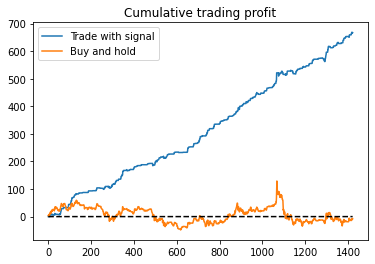

In [ ]:
profit = []
profit_buyandhold = []
t = 0

# compute the profit every 6 time steps
while 6*t < data.shape[0]:
    profit.append(data.loc[6*t, 'theta'] * data.loc[6*t, 'mid(t+6)-mid(t)'])
    profit_buyandhold.append(data.loc[6*t, 'mid(t+6)-mid(t)'])
    t = t + 1

plt.plot(np.cumsum(profit), label='Trade with signal')
plt.plot(np.cumsum(profit_buyandhold), label='Buy and hold')
plt.plot(np.zeros_like(profit_buyandhold), 'k--')
plt.legend()
plt.title('Cumulative trading profit')

In general the algo-trading rule seems to outperform the simple "buy-and-hold" strategy. But note that our profit calculation is just an approximation, which has not taken transaction costs or bid-ask spread into the account yet.